# Fruits and Vegetables classifier

## Import Libraries

In [2]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import matplotlib.pyplot as plt


## Constants and Paths

In [ ]:
# Define constants and paths
im_shape = (250, 250)
TRAINING_DIR = r'dataset/train'
TEST_DIR = r'dataset/test'
seed = 10
BATCH_SIZE = 64
epochs = 20

## Load the data generators

In [ ]:
data_generator = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
    class_mode='categorical', batch_size=BATCH_SIZE, subset="training"
)

validation_generator = val_data_generator.flow_from_directory(
    TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
    class_mode='categorical', batch_size=BATCH_SIZE, subset="validation"
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
    class_mode='categorical', batch_size=BATCH_SIZE
)
global num_classes, nb_train_samples, nb_validation_samples, nb_test_samples, classes

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes = len(classes)

## Define the CNN mmodel

In [ ]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

## Compile and Train the model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

callbacks_list = [
    keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
]

history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    verbose=1,
    validation_steps=nb_validation_samples // BATCH_SIZE
)


## Visualize Training Curves

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

## Evaluate the model on validation and test sets

In [ ]:
best_model = keras.models.load_model('model/best_model.h5')
score_val = best_model.evaluate(validation_generator)
score_test = best_model.evaluate(test_generator)


In [ ]:
print('Validation loss:', score_val[0])
print(f'\nValidation accuracy:{round(score_val[1]*100,2)}%')

print('\nTest loss:', score_test[0])
print(f'\nTest accuracy:{round(score_test[1]*100,2)}%')

## Plotting Test Images with Prediction

In [ ]:
def plot_test_images_with_predictions(model, test_generator, num_images=9):
    test_images, true_labels = test_generator.next()
    predictions = model.predict(test_images)
    predicted_labels = [classes[np.argmax(pred)] for pred in predictions]

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(test_images[i])
        plt.title(f'Predicted: {predicted_labels[i]}\nTrue: {classes[np.argmax(true_labels[i])]}')
        plt.axis('off')

    plt.show()

# Plot test images with predictions
plot_test_images_with_predictions(best_model, test_generator, num_images=9)


In [ ]:
Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')



In [ ]:
#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

## Inference

1/1 [==============================] - 14s 14s/step


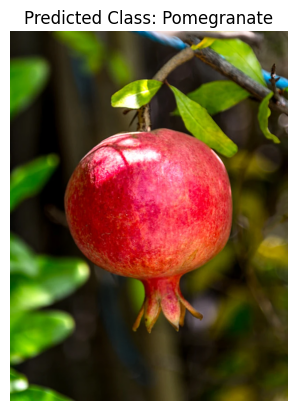

In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('model/best_model.h5')

# Function to preprocess the input image
def preprocess_input_image(img_path):
    img = image.load_img(img_path, target_size=(250, 250))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image
    return img

# Function to predict the class of the object in the image
def predict_class(img_path, model):
    preprocessed_img = preprocess_input_image(img_path)
    predictions = model.predict(preprocessed_img)
    class_index = np.argmax(predictions)
    return class_index

# Provide the path to your input image
input_image_path = 'test_image_4.jpg'

# Predict the class of the object in the image
predicted_class_index = predict_class(input_image_path, model)

class_labels = ['Amaranth', 'Apple', 'Apricot', 'Asparagus', 'Avocado', 'Banana', 'Beans', 'Beetroot', 'Bell Pepper', 'Bitter Gourd', 'Black Berry', 'Black Current', 'Blueberry', 'Bottle Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cashew', 'Cauliflower', 'Chikoo', 'Chilli', 'Coconut', 'Corn', 'Cranberry', 'Cucumber', 'Custard Apple', 'Dates', 'Dragon Fruit', 'Elderberry', 'Fig', 'Garlic', 'Ginger', 'Gooseberry', 'Grapes', 'Guava', 'Jackfruit', 'Kiwi', 'Lemon', 'Lettuce', 'Litchi', 'Longan', 'Mango', 'Mushroom', 'Muskmelon', 'Okra', 'Olive', 'Onion', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Peas', 'Pineapple', 'Plum', 'Pomegranate', 'Potato', 'Pumpkin', 'Radish', 'Rambutan', 'Raspberry', 'Ridge Gourd', 'Spinach', 'Strawberry', 'Sweet Potato', 'Tamarind', 'Taro Roots', 'Tinda', 'Tomato', 'Turnip', 'Watermelon', 'Wax Gourd', 'Wood Apple', 'Yam', 'Zucchini']
predicted_class_label = class_labels[predicted_class_index]

# Display the input image and predicted class
img = image.load_img(input_image_path)
plt.imshow(img)
plt.axis('off')
plt.title('Predicted Class: ' + predicted_class_label)
plt.show()



## Nutrition Values

In [5]:
import pandas as pd

nutrition_data=pd.read_csv('dataset/nutrition_values.csv')

# Function to get the nutrition values of the predicted class
def get_nutrition_values(predicted_class_label, nutrition_data):
    # Find the row where the 'Name' column matches the predicted class label
    nutrition_values = nutrition_data.loc[nutrition_data['Name'] == predicted_class_label]
    return nutrition_values

nutrition_values = get_nutrition_values(predicted_class_label, nutrition_data)

nutrition=nutrition_values.to_dict()

flattened_dict = {}
for key, inner_dict in nutrition.items():
    for inner_key, value in inner_dict.items():
        flattened_dict[key] = value


flattened_dict

{'Name': 'Pomegranate',
 'Calories (per 100g)': 83,
 'Carbohydrates (g)': 18.7,
 'Protein (g)': 1.7,
 'Fat (g)': 1.7,
 'Fiber (g)': 4.0,
 'Vitamin C (mg)': 10.2,
 'Zinc (mg)': 0.3,
 'Potassium (mg)': 236,
 'Iron (mg)': 0.3,
 'Calcium (mg)': 10}